# Unsupervised Learning Capstone 4

## Background

#### Children's books have been around for centuries. In this capstone, I have used natural language processing along with multiple machine learning algorithims in order to examine the text and classify it to the right book. There are 10 different books with 10 different authors. Having books under the same genre can make classification difficult, and this is the challenge of our capstone. 

#### Our books come from Project Gutenberg, an open source library that has a wide variety of books easily available for download. The goal of this capstone it to see whether through the use of unsupervised learning, our models would be able to determine which text belongs to the right book. 

### Let's get started

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string
import spacy
from nltk.corpus import stopwords, gutenberg
import spacy
from spacy.pipeline import SentenceSegmenter
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en')
#import nltk 
#from nltk.corpus import stopwords set(stopwords.words('english'))

from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
from spacy.pipeline import SentenceSegmenter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
# Evaluate the performance of the clusters


from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
import scikitplot.plotters as skplt
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

### Loading Data

In [2]:
#loadind data using gutenberg import
Oz= strip_headers(load_etext(55)).strip()
Anne= strip_headers(load_etext(45)).strip()
Alice= strip_headers(load_etext(19002)).strip()
Christmas= strip_headers(load_etext(19337)).strip()
Peter= strip_headers(load_etext(16)).strip()
Gulliver= strip_headers(load_etext(829)).strip()
Huckleberry= strip_headers(load_etext(76)).strip()
Moby= strip_headers(load_etext(2701)).strip()
Robinson= strip_headers(load_etext(521)).strip()
Prince= strip_headers(load_etext(1232)).strip()

### Data Cleaning

In [3]:
#round 1 of cleaning data
def text_cleaner_1(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--', ' ',text)
    #remove brackets
    text = re.sub("[\[].*?[\]]", '', text)
    #remove volume
    text = re.sub(r'VOLUME \w', '', text)
    #remove words contaning numbers
    text = re.sub('\w*\d\w*', '', text)
    #remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Search for all non-letters
    # Replace all non-letters with spaces
    # Remove story section separators, add uniform story section separator
    text = re.sub('(\s*\*){5}', '@SentBoundary@' , text)
    text = re.sub(r'C[Hh][Aa][Pp][Tt][Ee][Rr] [\d\w]+', '@SentBoundary@' , text)
    #text = re.sub("[^a-zA-Z]", " ", str(text))
    #remove white space
    tex= text.lower()
    text = ' '.join(text.split())
    return text

In [4]:
# Had to limit my values to 100,000. It was causing errors after splitting data. 
Oz=text_cleaner_1(Oz)[:100000]
Anne= text_cleaner_1(Anne)[:100000]
Alice=text_cleaner_1(Alice)[:100000]
Christmas=text_cleaner_1(Christmas)[:100000]
Peter=text_cleaner_1(Peter)[:100000]
Gulliver= text_cleaner_1(Gulliver)[:100000]
Huckleberry=text_cleaner_1(Huckleberry)[:100000]
Moby=text_cleaner_1(Moby)[:100000]
Robinson=text_cleaner_1(Robinson)[:100000]
Prince=text_cleaner_1(Prince)[:100000]

In [5]:
books= [Oz, Anne, Alice, Christmas, Peter, Gulliver, Huckleberry, Moby, Robinson, Prince]

for i in books:
    print (len(i))

100000
100000
77600
100000
100000
100000
100000
100000
100000
100000


In [6]:
#lowering all texts now. For some reason, it was throwing an error when I lower after tokenization. 
Oz=Oz.lower()
Anne=Anne.lower()
Alice=Alice.lower()
Christmas=Christmas.lower()
Peter=Peter.lower()
Gulliver=Gulliver.lower()
Huckleberry= Huckleberry.lower()
Moby=Moby.lower()
Robinson=Robinson.lower()
Prince=Prince.lower()

In [7]:
#Adding pipeline to split on Sentence Boundary. This should prevent @SentBoundary@ being tokenized.
def split_on_breaks(doc):
    start = 0
    seen_break = False
    for word in doc:
        if seen_break:
            yield doc[start:word.i-1]
            start = word.i  
            seen_break = False
        elif word.text == '@sentboundary@':
            seen_break = True
    if start < len(doc):
        yield doc[start:len(doc)]

sbd = SentenceSegmenter(nlp.vocab, strategy=split_on_breaks)
nlp.add_pipe(sbd, first=True)

In [8]:
#loading nlp and converting documents to nlp
nlp = spacy.load('en')
Oz_doc = nlp(Oz)
Anne_doc = nlp(Anne)
Alice_doc = nlp(Alice)
Christmas_doc = nlp(Christmas)
Peter_doc = nlp(Peter)
Gulliver_doc = nlp(Gulliver)
Huckleberry_doc = nlp(Huckleberry)
Moby_doc = nlp(Moby)
Robinson_doc = nlp(Robinson)
Prince_doc= nlp(Prince)


## Exploring the data

### Breaking apart into sentences or sentences segmentation.

In [9]:
Oz_sents = [[sent, 'Oz'] for sent in Oz_doc.sents]
Anne_sents = [[sent, 'Anne'] for sent in Anne_doc.sents]
Alice_sents = [[sent, 'Alice'] for sent in Alice_doc.sents]
Christmas_sents = [[sent, 'Christmas'] for sent in Christmas_doc.sents]
Peter_sents = [[sent, 'Peter'] for sent in Peter_doc.sents]
Gulliver_sents = [[sent, 'Gulliver'] for sent in Gulliver_doc.sents]
Huckleberry_sents = [[sent, 'Huckleberry'] for sent in Huckleberry_doc.sents]
Moby_sents = [[sent, 'Moby'] for sent in Moby_doc.sents]
Robinson_sents = [[sent, 'Robinson'] for sent in Robinson_doc.sents]
Prince_sents = [[sent, 'Prince'] for sent in Prince_doc.sents]

In [10]:
#creating dataframe for all sentences
sentences_df = pd.DataFrame(Oz_sents + Anne_sents + Alice_sents + Christmas_sents +
                        Peter_sents + Gulliver_sents + Huckleberry_sents +
                        Moby_sents + Robinson_sents + Prince_sents)

In [11]:
sentences_df.columns = ['text_sentences', 'text']
sentences_df.head()

,text_sentences,text
0,"(the, wonderful, wizard, of, oz, by, l, frank,...",Oz
1,"(the, good, witch, grants, dorothys, wish, home)",Oz
2,"(again, introduction, folklore, legends, myths...",Oz
3,"(wife, their, house, was, small, for, the, lum...",Oz
4,"(many, miles, there, were, four, walls, a, flo...",Oz


In [12]:
sentences_df.shape

(7798, 2)

In [13]:
sentences_df.drop(sentences_df[sentences_df.text_sentences.apply(len) == 0].index, inplace=True, axis=0)
sentences_df.reset_index(inplace=True, drop=True)

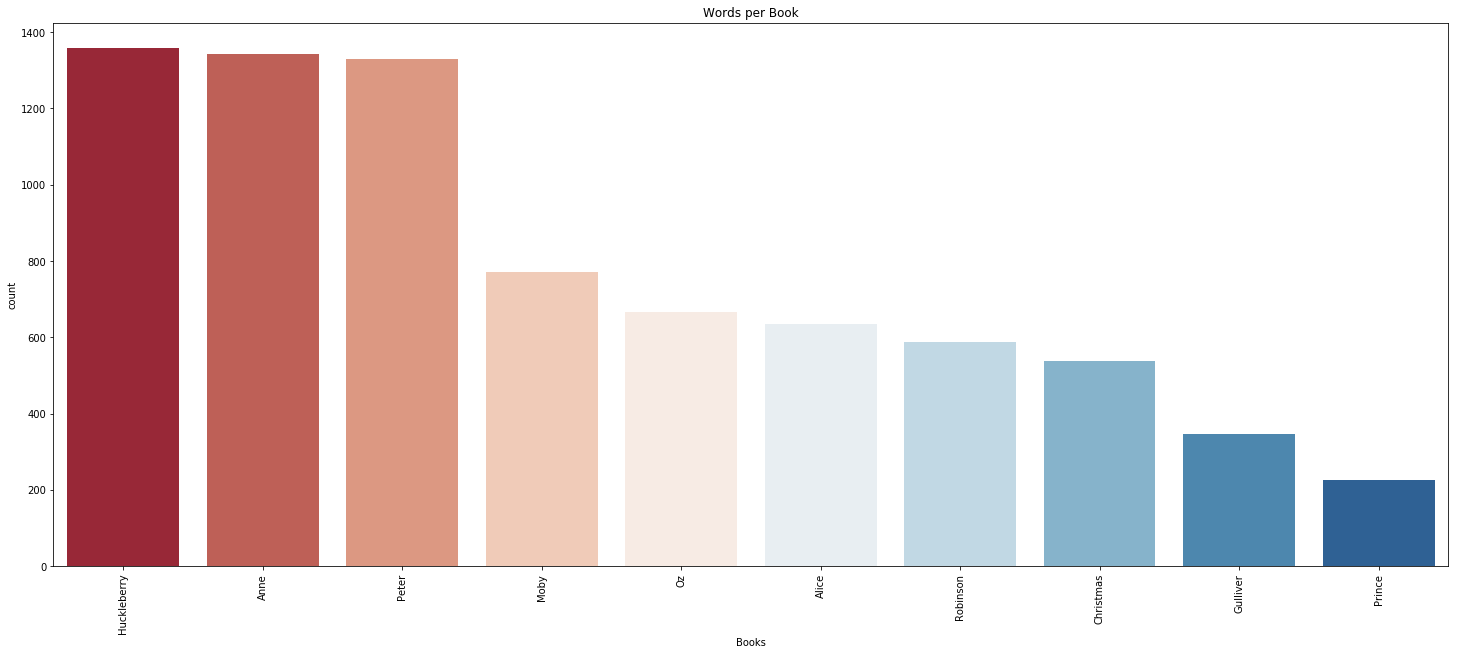

In [14]:
# Here I am looking at the distribution of sections and works by each book.
book_sample_count_df = sentences_df.groupby('text').filter(lambda x: len(x) > 100)
varieties = book_word_count_df['text'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = book_word_count_df['text'], order = varieties, ax = ax, palette='RdBu')
plt.title('Words per Book')
plt.xlabel('Books')
plt.xticks(rotation = 90)
plt.show()

### Lemmatization and Parts of Speech

In [15]:
# Convert to lemma
# Converting sentences to parts of speech
lemma_sents = [' '.join([token.lemma_ for token in sent]) for sent in sentences_df['text_sentences']]
sents_pos = [' '.join([token.pos_ for token in sent]) for sent in sentences_df['text_sentences']]

In [16]:
#Using parts of speech later on. 
vectorizer_pos = CountVectorizer()
X_pos = vectorizer_pos.fit_transform(sents_pos)
columns_pos = list(vectorizer_pos.get_feature_names())
print(columns_pos[0:20])
print(X_pos.toarray())  

df_pos = pd.DataFrame(X_pos.toarray(), columns=columns_pos)
df_pos.head()

['adj', 'adp', 'adv', 'aux', 'cconj', 'det', 'intj', 'noun', 'num', 'part', 'pron', 'propn', 'punct', 'sym', 'verb']
[[11 16  4 ...  0  0  9]
 [ 2  0  0 ...  0  0  1]
 [25 27  9 ...  0  0 38]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 3 17  2 ...  0  0 14]
 [ 1  2  1 ...  0  0  2]]


,adj,adp,adv,aux,cconj,det,intj,noun,num,part,pron,propn,punct,sym,verb
0,11,16,4,0,0,34,0,44,0,0,0,0,0,0,9
1,2,0,0,0,0,1,0,3,0,0,0,0,0,0,1
2,25,27,9,0,11,32,0,65,0,4,4,0,0,0,38
3,1,2,0,0,0,2,0,3,0,2,1,0,0,0,6
4,2,1,1,0,5,9,0,15,4,0,0,0,0,0,4


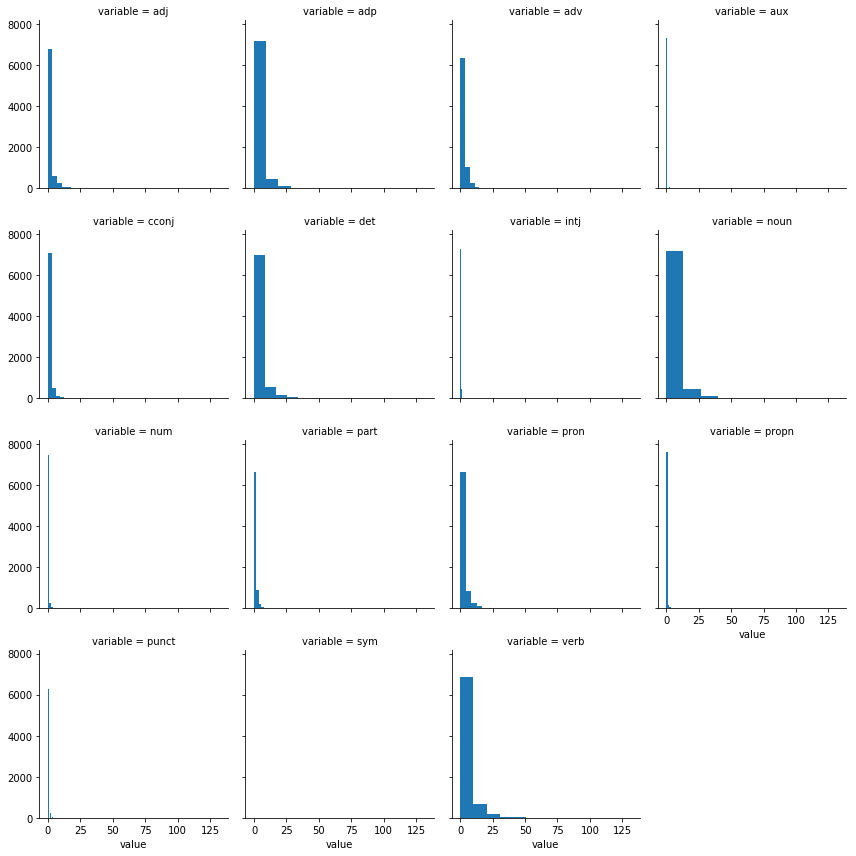

In [17]:
g = sns.FacetGrid(df_pos.melt(), col='variable', col_wrap=4, height=3,)
g.map(plt.hist, 'value')
plt.show()


Not all of the parts of speech are useful. We can see that some parts of speech are used more often than others. We can eliminate some for modeling later. 

## Bag of Words

#### First I've created a bag of words. SpaCy has already tokenized our text.  We will exclude stopwords and punctuation. We will be using only 2000 features. 

In [18]:
from sklearn.feature_extraction import text
#extended punctuation list
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
#stopwords_en = stopwords.words('english')

#create a bag of words using CountVectorizer.
vectorizer = CountVectorizer(max_features=2000,
                             #analyzer='word',
                             min_df=5, 
                             stop_words=stop_words,
                             #tokenizer='callable',
                             ngram_range=(1, 1))
X = vectorizer.fit_transform(lemma_sents)
#extracting features 
columns = list(vectorizer.get_feature_names())
print('There are {} features'.format(len(columns)))
print(columns[0:20])

# Convert bag of words to a dataframe
df_bow = pd.DataFrame(X.toarray(), columns=columns)
df_bow.head()

There are 2000 features
['abate', 'ability', 'able', 'abreast', 'abroad', 'abundance', 'accept', 'accident', 'accompany', 'accord', 'accordingly', 'account', 'accustom', 'accustomed', 'acquire', 'act', 'action', 'ad', 'add', 'address']


,abate,ability,able,abreast,abroad,abundance,accept,accident,accompany,accord,...,ye,year,yellow,yes,yesterday,yield,yo,young,yous,youth
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#splitting data us bag of words df
X_train, X_test, y_train, y_test = train_test_split(df_bow, 
                                                    sentences_df['text'], 
                                                    test_size=0.25, 
                                                    random_state=0)

## Now it's time to put our Bag of Words to test. Let's try out some models.  

### Random Forest and Bag of Words

In [20]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier(n_estimators= 200, max_depth=15, min_samples_split= 4)
random_forest= rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.5102599179206566

Test set score: 0.4774358974358974


Feature ranking:
1. feature 48 (0.0620) alice
2. feature 1531 (0.0512) scrooge
3. feature 516 (0.0487) dorothy
4. feature 1930 (0.0357) wendy
5. feature 1088 (0.0332) marilla
6. feature 1300 (0.0288) peter
7. feature 1524 (0.0243) scarecrow
8. feature 59 (0.0241) anne
9. feature 1934 (0.0232) whale
10. feature 752 (0.0230) ghost
11. feature 1102 (0.0213) matthew
12. feature 1255 (0.0185) oz
13. feature 569 (0.0184) en
14. feature 1971 (0.0174) woodman
15. feature 1030 (0.0167) lion
16. feature 1375 (0.0163) pron
17. feature 430 (0.0153) darling
18. feature 1363 (0.0144) prince
19. feature 1578 (0.0127) ship
20. feature 1819 (0.0120) tin


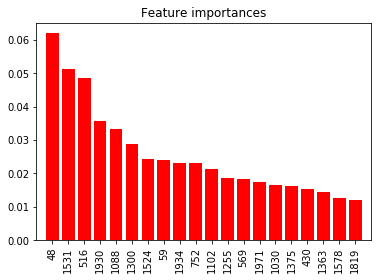

In [21]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

terms = vectorizer.get_feature_names()

for f in range(20):
    print('{}. feature {} ({:.4f}) {}'.format((f+1), indices[f], importances[indices[f]], terms[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), indices, rotation=90)
plt.xlim([-1, 20])
plt.show()

#### It's interesting that the names of major characters come up. I've decided not to clean the names out since it might be useful in classifying the text.

### Gradient Boosting Classifier

In [22]:
clf = ensemble.GradientBoostingClassifier(n_estimators=200, min_samples_split=2)
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.7354651162790697

Test set score: 0.581025641025641


#### This is highly overfitted. I've tried adding parameters and tuning it but it only gave worse scores. For now, I'm sticking with these.

## Now trying out our Bag of Words with Clustering 

#### The point of using clusters is to group the texts together to see if the clusters group accordingly to their author. Here we'll look at K-means, Mean Shift and Spectral Clustering. I've also tried to include Affinity Propagation, however, it is computationaly expensive and very time consuming. Therefore, I stuck with three forms of clustering. 

### K means  

In [23]:
from sklearn.cluster import KMeans

# I've changed the clusters to 5 since our elbow method shows 5 is the optimal number of clusters as demonstrated
#below. 
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=20)

# Fit and predict the model. 
y_pred = kmeans.fit_predict(X_train)

pd.crosstab(y_train, y_pred)

col_0,0,1,2,3,4
text,,,,,
Alice,217,58,13,177,0
Anne,616,62,9,338,0
Christmas,179,70,29,139,0
Gulliver,90,51,26,80,4
Huckleberry,678,66,14,247,0
Moby,400,41,12,121,0
Oz,186,84,30,188,1
Peter,596,102,18,293,0
Prince,42,40,28,49,13


In [24]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
# Evaluate the performance of the clusters

print('Adjusted Rand Score: {:.2f}'.format(adjusted_rand_score(y_train, y_pred)))
print('Silhouette Score: {:.2f}'.format(silhouette_score(X_train, y_pred, metric='euclidean')))

Adjusted Rand Score: 0.03
Silhouette Score: 0.22


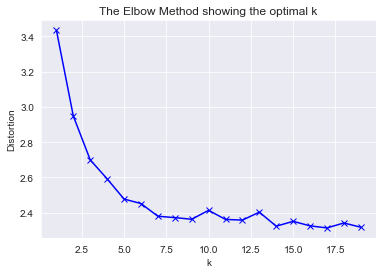

In [25]:
from scipy.spatial.distance import cdist
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_train)
    kmeanModel.fit(X_train)
    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_train.shape[0])

# Plot the elbow
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### These are really bad scores. Our ARI only scores 0.03, which means that the clusters of data do not agree on any pair of points and is close to random. Our silhouette score is only 0.22. Let's try out other forms of clustering.

### Meanshift

In [26]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=200)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 44


In [27]:
#plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
#plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))
print('\nAdjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train, 
                                                                         labels)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train, 
                                                                 labels, 
                                                                 metric='euclidean')))

Comparing the assigned categories to the ones in the data:
col_0         0   1   2   3   4   5   6   7   8   9   ...  34  35  36  37  38  \
text                                                  ...                       
Alice        371   0   9   0  22   9   1   1   1   1  ...   1   0   0   0   0   
Anne         931   0   8   0  13   0   0   0   5   0  ...   1   0   5   0   3   
Christmas    303   0   9   0  30   1   0   0   0   0  ...   0   2   0   0   0   
Gulliver     165   0   3   0  42   0   0   0   0   0  ...   1   0   0   2   0   
Huckleberry  904   0  16   0  17   0   0   0   0   0  ...   0   0   2   0   0   
Moby         496  13   3   0  19   0   0   0   0   0  ...   1   0   0   1   0   
Oz           360   0  15   0  32   0   0   0   0   1  ...   1   0   0   0   0   
Peter        866   2  11   0  32   0   0   0   2   1  ...   8   2   0   6   0   
Prince        83   0  11   1  48   0   0   0   0   1  ...   0   1   0   0   0   
Robinson     321   0   8   0  27   0   0   0   0  

### Spectral Clustering

In [28]:
n_clusters = 5

sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

y_pred_spectral=sc.fit_predict(X_train)


pd.crosstab(y_train, y_pred_spectral)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  n_init=n_init)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  n_init=n_init)


col_0,1,2,3,4
text,,,,
Alice,0,0,0,465
Anne,0,0,0,1025
Christmas,0,0,0,417
Gulliver,0,0,0,251
Huckleberry,0,0,0,1005
Moby,0,0,0,574
Oz,0,0,0,489
Peter,0,0,0,1009
Prince,1,0,1,170


In [29]:
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train, 
                                                                       y_pred_spectral)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train, 
                                                                y_pred_spectral, 
                                                                metric='euclidean')))

Adjusted Rand Index: 0.00
Silhouette Score: 0.87


## Truncated bag of words or SVD

#### We can use dimension reduction via Singular Value Decomposition. Let's give it a try with our Bag of Words and see if it will improve scores. 

In [30]:

svd = TruncatedSVD(n_components=20, n_iter=25, random_state=0)
truncated_bag_of_words = svd.fit_transform(df_bow)

X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(truncated_bag_of_words, 
                                                    sentences_df['text'], 
                                                    test_size=0.25, 
                                                    random_state=0)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 63.73344612383362


### K Means with SVD 

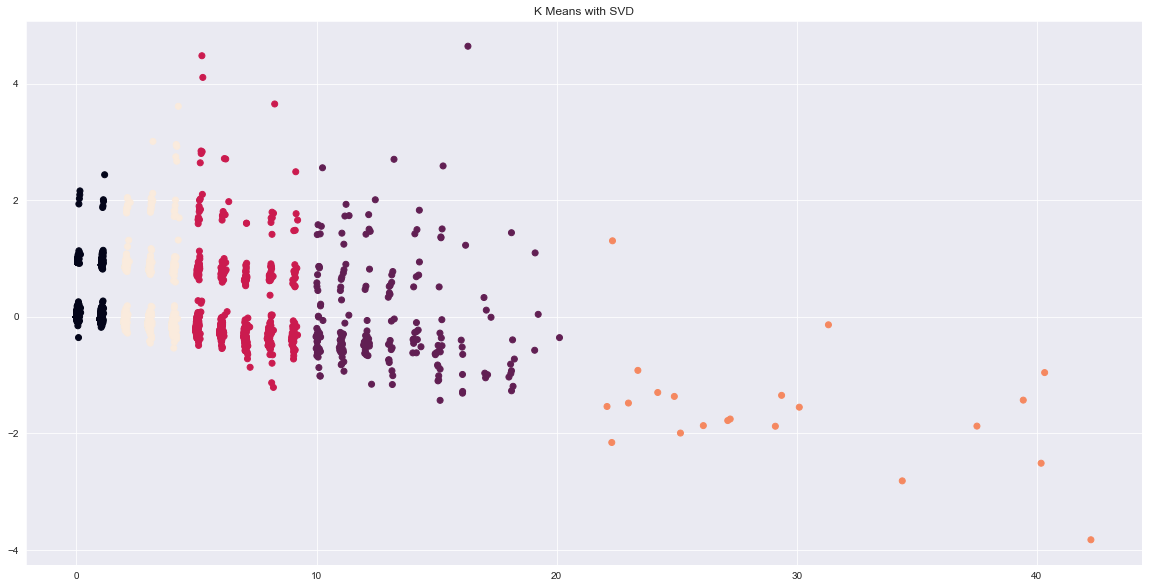

col_0,0,1,2,3,4
text,,,,,
Alice,217,13,58,0,177
Anne,616,9,62,0,338
Christmas,179,29,70,0,139
Gulliver,90,26,51,4,80
Huckleberry,678,14,66,0,247
Moby,400,12,41,0,121
Oz,186,30,84,1,188
Peter,596,18,102,0,293
Prince,42,28,40,13,49


In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=20)

# Fit and predict the model. 
y_pred = kmeans.fit_predict(X_train_svd)

plt.figure(figsize=(20,10))
plt.scatter(X_train_svd[:, 0], X_train_svd[:,1], c=y_pred )
plt.title('K Means with SVD')
plt.show()
pd.crosstab(y_train_svd, y_pred)

In [32]:
print('Adjusted Rand Score: {:.2f}'.format(adjusted_rand_score(y_train_svd, y_pred)))
print('Silhouette Score: {:0.2f}'.format(silhouette_score(X_train_svd, y_pred, metric='euclidean')))

Adjusted Rand Score: 0.03
Silhouette Score: 0.46


### Mean Shift with SVD

Number of estimated clusters: 11


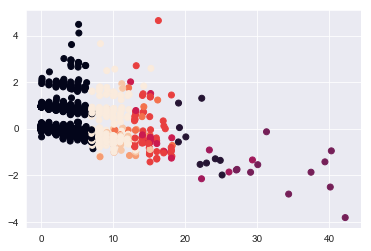

Comparing the assigned categories to the ones in the data:
col_0          0   1   2   3   4   5   6   7   8   9   10
text                                                     
Alice         437   0   0   0   0   2   3   0   0   4  19
Anne         1001   0   0   0   0   1   2   0   0   0  21
Christmas     369   1   0   0   0   0   8  12   0   2  25
Gulliver      195   1   0   3   0   1   9   0   1   4  37
Huckleberry   970   0   0   0   0   0   2   0   0   3  30
Moby          536   0   8   0   0   2   1   0   0   3  24
Oz            436   1   0   0   0   4   6   0   0   2  40
Peter         965   0   1   0   0   2   5   1   0   2  33
Prince        116   5   0   5   4   1  11   0   5   3  22
Robinson      387   2   0   3   0   1   9   0   0   6  33


In [33]:
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=200)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_svd)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))


In [34]:
print('Adjusted Rand Score: {:.2f}'.format(adjusted_rand_score(y_train_svd, y_pred)))
print('Silhouette Score: {:0.2f}'.format(silhouette_score(X_train_svd, y_pred, metric='euclidean')))

Adjusted Rand Score: 0.03
Silhouette Score: 0.46


### Spectral Clustering with SVD

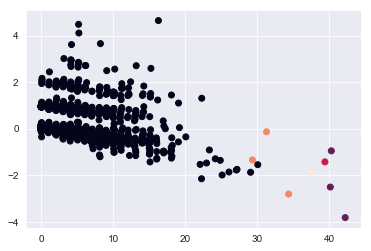

In [35]:
n_clusters = 5

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)

sc.fit(X_train_svd)

#Predicted clusters.
y_pred_spectral=sc.fit_predict(X_train_svd)

#Graph results.
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_pred_spectral)
plt.show()


In [36]:
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train_svd, 
                                                                       y_pred_spectral)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_svd, 
                                                                y_pred_spectral, 
                                                                metric='euclidean')))

Adjusted Rand Index: 0.00
Silhouette Score: 0.88


### Let's try a different approach. We can use Tf_Idf  or term frequency–inverse document frequency, to represent the weights of words in our books. If used with SVD, tf_idf is also know as a Latent Semantic Analysis where context or concepts from words are extracted and assumes that words are close in meaning will transpire in similar texts. 

In [37]:
# Split original into train and test, used to look at text later
from sklearn.feature_extraction import text
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%", 'pron']
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

X_train, X_test, y_train, y_test = train_test_split(lemma_sents, 
                                                    sentences_df['text'], 
                                                    test_size=0.25, 
                                                    random_state=0)

#creating our Tf_idf vectorizer
vectorizer_tfidf = TfidfVectorizer(max_df= 0.80, # drop words that occur in more than this % of paragraphs
                             min_df=5, # only use words that appear at least 10 times
                             stop_words=stop_words, 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


# Fit and transform training data set, only transform test
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

print("Number of features: %d" % X_train_tfidf.get_shape()[1])

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer_tfidf.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# This output is long, so suppressed, but interesting for debugging
# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 
# indicates that the word was present once in that sentence.
# print('Original section:', X_train[1])
# print('Tf_idf vector:', tfidf_bypara[1])

df_tfidf_train = pd.DataFrame(X_train_tfidf.toarray(), columns=list(terms))
df_tfidf_test = pd.DataFrame(X_test_tfidf.toarray(), columns=list(terms))

# This is a little redundant, but used later to join with the full dataframe, could also join 
# the train and test dataframes
df_tfidf = pd.DataFrame(vectorizer_tfidf.transform(lemma_sents).toarray(), columns=list(terms))

# Reduce number of features
svd = TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Fit model to training data, transform both training and test
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: {:.2f}".format(total_variance*100))

Number of features: 1914
Percent variance captured by all components: 89.90


### Random Forest with Tf_idf

In [38]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier(n_estimators= 400, max_depth=20, min_samples_split= 10)


train = rfc.fit(X_train_tfidf, y_train)

print('Training set score:', rfc.score(X_train_tfidf, y_train))
print('\nTest set score:', rfc.score(X_test_tfidf, y_test))

Training set score: 0.5309507523939808

Test set score: 0.4938461538461538


Feature ranking:
1. feature 46 (0.0634) alice
2. feature 1466 (0.0481) scrooge
3. feature 485 (0.0420) dorothy
4. feature 1022 (0.0355) marilla
5. feature 1226 (0.0342) peter
6. feature 1845 (0.0324) wendy
7. feature 1849 (0.0309) whale
8. feature 1032 (0.0237) matthew
9. feature 57 (0.0226) anne
10. feature 1456 (0.0217) scarecrow
11. feature 1177 (0.0211) oz
12. feature 538 (0.0209) en
13. feature 967 (0.0181) lion
14. feature 716 (0.0174) ghost
15. feature 1509 (0.0163) ship
16. feature 1294 (0.0148) prince
17. feature 1829 (0.0125) warnt
18. feature 1887 (0.0125) woodman
19. feature 408 (0.0116) darling
20. feature 887 (0.0113) john


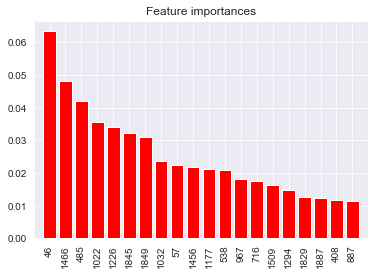

In [39]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

terms = vectorizer_tfidf.get_feature_names()

for f in range(20):
    print('{}. feature {} ({:.4f}) {}'.format((f+1), indices[f], importances[indices[f]], terms[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), indices, rotation=90)
plt.xlim([-1, 20])
plt.show()

### The names are still appearing as important features, which is expected because most of the names are unique to the books like Alice from Alice in Wonderland and Dorothy from Peter Pan. 

### Random Forest with LSA

In [40]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier(n_estimators= 250, max_depth=20, min_samples_split= 10)

train = rfc.fit(X_train_lsa, y_train)

print('Training set score:', rfc.score(X_train_lsa, y_train))
print('\nTest set score:', rfc.score(X_test_lsa, y_test))

Training set score: 0.8773939808481532

Test set score: 0.5046153846153846


### Gradient Boosting with Tf_idf

In [41]:
clf = ensemble.GradientBoostingClassifier(n_estimators=200, min_samples_split=2)
train = clf.fit(X_train_tfidf, y_train)

print('Training set score:', clf.score(X_train_tfidf, y_train))
print('\nTest set score:', clf.score(X_test_tfidf, y_test))

Training set score: 0.8036935704514364

Test set score: 0.5502564102564103


### Gradient Boosting with LSA

In [42]:
clf = ensemble.GradientBoostingClassifier(n_estimators=200, min_samples_split=2)
train = clf.fit(X_train_lsa, y_train)

print('Training set score:', clf.score(X_train_lsa, y_train))
print('\nTest set score:', clf.score(X_test_lsa, y_test))

Training set score: 0.8683310533515732

Test set score: 0.5476923076923077


These models are overfitting. After trying several tuning of parameters, these are the best results I can get. 

## Clustering with Tf_Idf and LSA

### K-Means with Tf_idf 

In [43]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=30)

# Fit and predict the model. 
y_pred = kmeans.fit_predict(X_train_tfidf)

pd.crosstab(y_train, y_pred)

col_0,0,1,2,3,4
text,,,,,
Alice,61,225,63,99,17
Anne,159,644,78,109,35
Christmas,89,231,40,44,13
Gulliver,88,144,0,16,3
Huckleberry,256,568,84,67,30
Moby,105,406,10,44,9
Oz,141,215,41,73,19
Peter,183,592,87,104,43
Prince,73,93,1,5,0


In [44]:
print('Adjusted Rand Score: {:.2f}'.format(adjusted_rand_score(y_train, y_pred)))
print('Silhouette Score: {:.2f}'.format(silhouette_score(X_train_tfidf, y_pred, metric='euclidean')))

Adjusted Rand Score: 0.01
Silhouette Score: 0.05


### K-means and LSA

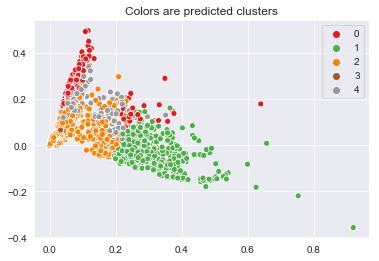

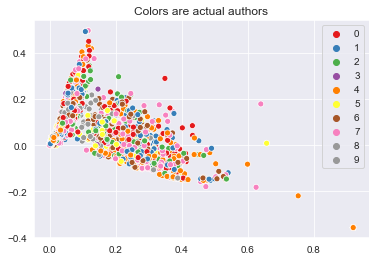

Comparing k-means clusters against the data:
col_0         0   1    2   3    4
text                             
Alice        19  69  275   0  102
Anne         35  87  776   0  127
Christmas    13  50  305   0   49
Gulliver      3   2  224   0   22
Huckleberry  33  96  729  57   90
Moby         11  15  499   0   49
Oz           22  52  337   0   78
Peter        44  97  705   0  163
Prince        0   2  161   0    9
Robinson     14  22  342   0   63

Adjusted Rand Index: -0.00
Silhouette Score: 0.05
Cluster 0: know say peter thing mean think want little heart long come child
Cluster 1: say alice scrooge peter matthew marilla john come little good like dorothy
Cluster 2: make time like good oh little tell thing man way great just
Cluster 3: en er git gwyne dat cent yous dollar place rich kill wuz
Cluster 4: come think look wendy want say time little just like make head


In [45]:
n_clusters=5
km = KMeans(n_clusters=n_clusters, n_init=30, random_state=0)
y_pred = km.fit_predict(X_train_lsa)

# Plot the solution.
sns.scatterplot(X_train_lsa[:, 0], X_train_lsa[:, 1], hue=y_pred, legend='full', palette='Set1')
plt.title('Colors are predicted clusters')
plt.show()

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)

sns.scatterplot(X_train_lsa[:, 0], X_train_lsa[:, 1], hue=y_train_enc, legend='full', palette='Set1')
plt.title('Colors are actual authors')
plt.show()
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, y_pred))


print('\nAdjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train, y_pred)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_lsa, 
                                                                 y_pred, 
                                                                 metric='euclidean')))

# Find the words corresponding to the cluster centroids
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = vectorizer_tfidf.get_feature_names()
for i in range(5):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :12]:
        print(' %s' % terms[ind], end='')
    print()

### Mean Shift and LSA

Number of estimated clusters: 9


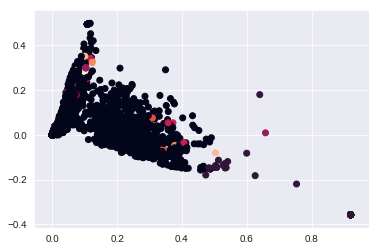

Comparing the assigned categories to the ones in the data:

Adjusted Rand Index: -0.00
Silhouette Score: 0.03


In [47]:
#Mean shift with tf_idf was eliminated due to errors. 
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.1, n_samples=200)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
pd.crosstab(y_train,labels)

print('\nAdjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train, labels)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_lsa, 
                                                                 labels)))

### Spectral Clustering and Tf_idf

In [48]:
n_clusters = 5

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)

sc.fit(X_train_tfidf)

#Predicted clusters.
y_pred_spectral=sc.fit_predict(X_train_tfidf)

#Graph results.
#plt.scatter(X_train_tfidf[:, 0], X_train_tfidf[:, 1], c=y_pred_spectral)
#plt.show()

print('Comparing the assigned categories to the ones in the data:')
pd.crosstab(y_train, y_pred_spectral)
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train, 
                                                                       y_pred_spectral)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_tfidf, 
                                                                y_pred_spectral, 
                                                                metric='euclidean')))

Comparing the assigned categories to the ones in the data:
Adjusted Rand Index: -0.00
Silhouette Score: 0.05


### Spectral Clustering with LSA

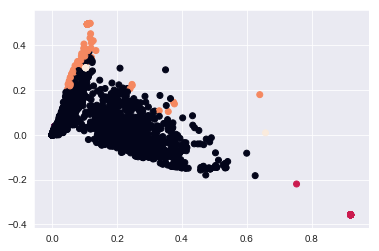

Comparing the assigned categories to the ones in the data:
Adjusted Rand Index: -0.00
Silhouette Score: 0.04


col_0,0,1,2,3,4
text,,,,,
Alice,451,0,1,11,2
Anne,999,0,7,19,0
Christmas,404,0,3,8,2
Gulliver,250,0,0,1,0
Huckleberry,937,30,12,22,4
Moby,567,0,0,5,2
Oz,477,0,2,9,1
Peter,971,0,16,19,3
Prince,172,0,0,0,0


In [49]:
n_clusters = 5

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)

sc.fit(X_train_lsa)

#Predicted clusters.
y_pred_spectral=sc.fit_predict(X_train_lsa)

#Graph results.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_pred_spectral)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train, 
                                                                       y_pred_spectral)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_lsa, 
                                                                y_pred_spectral, 
                                                                metric='euclidean')))
pd.crosstab(y_train, y_pred_spectral)

### We can explore parts of speech with TF_IDF and SVD. Let's see if the scores are any better here. 

In [50]:
sentences_df=sentences_df.join(df_pos)

In [51]:
sentences_df['word_count'] = sentences_df['text_sentences'].apply(len)-sentences_df['punct']
sentences_df['all_count'] = sentences_df['text_sentences'].apply(len)
sentences_df['all_caps'] = [sum([token.is_upper for token in sent]) for sent in sentences_df['text_sentences']]
sentences_df['exclamation'] = [sum([token.text == '!' for token in sent]) for sent in sentences_df['text_sentences']]
sentences_df['quotes'] = [sum([token.text == '"' for token in sent]) for sent in sentences_df['text_sentences']]
sentences_df['question'] = [sum([token.text == '!' for token in sent]) for sent in sentences_df['text_sentences']]

In [52]:
df_pos['all_caps'] =sentences_df['all_caps']
df_pos['exclamation'] = sentences_df['exclamation']
df_pos['question'] = sentences_df['question']
#Omitting sym,intj, almost no examples of it
df_pos_cols = ['noun', 'verb', 'adj', 'adv', 'adp', 'det', 'part', 'pron', 'propn', 'punct']

In [53]:
#Normalize POS data. 
norm = Normalizer(norm='l2')
Xpos_norm = norm.fit_transform(df_pos[df_pos_cols])

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(Xpos_norm, 
                                                    sentences_df['text'], 
                                                    test_size=0.25, 
                                                    random_state=0)

y_train_text, y_test_text = train_test_split(sentences_df['text'], test_size=0.25, random_state=0)

### K means with POS

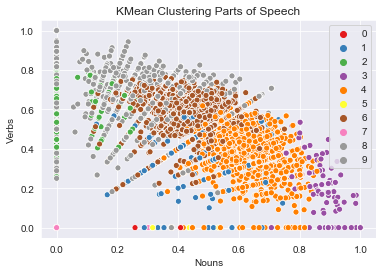

Comparing k-means clusters against the data:
col_0         0   1    2    3    4   5    6   7    8    9
text                                                     
Alice         0  27   41   18   95   0  148   5   56   75
Anne         53  64  126   85  161  37  216  21  124  138
Christmas     0  21   32   11  161   0  113  11   41   27
Gulliver      1   6   12    4  136   4   80   0    5    3
Huckleberry  40  50  151   82  157   8  211  35  151  120
Moby         29  39   27   57  196  31  102  20   43   30
Oz            0  23   32    0  124   0  167   3   78   62
Peter        68  34  102  120  138  43  252  22  122  108
Prince        0   7    2   10   58   0   81   1   10    3
Robinson     13   7   24   10  115   6  192   3   30   41
Adjusted Rand Index: -0.00
Silhouette Score: 0.21


In [54]:

y_pred = KMeans(n_clusters=10).fit_predict(X_train_pos)

sns.scatterplot(X_train_pos[:, 0], X_train_pos[:, 1], hue=y_pred, legend='full', palette='Set1')
plt.title('KMean Clustering Parts of Speech')
plt.xlabel('Nouns')
plt.ylabel('Verbs')
plt.show()


print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train_pos, y_pred))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train_pos, 
                                                                       y_pred)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_pos, 
                                                                y_pred, 
                                                                metric='euclidean')))

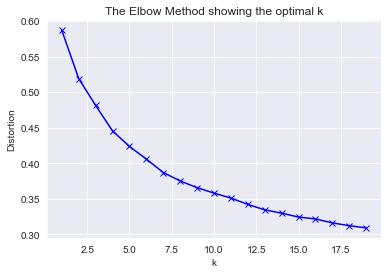

In [55]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_train_pos)
    kmeanModel.fit(X_train_pos)
    distortions.append(sum(np.min(cdist(X_train_pos, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_train_pos.shape[0])

# Plot the elbow
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Mean Shift with POS

Number of estimated clusters: 6


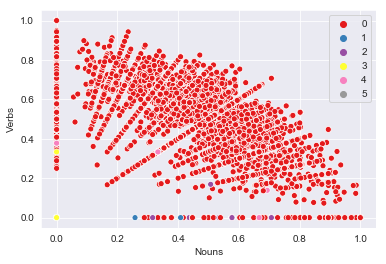

Comparing the assigned categories to the ones in the data:
col_0          0   1   2   3   4  5
text                               
Alice        453   0   0  10   1  1
Anne         877  58  45  41   3  1
Christmas    401   0   0  15   1  0
Gulliver     243   2   5   0   0  1
Huckleberry  893  43   9  46  12  2
Moby         475  31  37  24   7  0
Oz           484   0   0   4   1  0
Peter        848  83  48  26   2  2
Prince       170   0   0   2   0  0
Robinson     414  14   7   5   1  0

Adjusted Rand Index: -0.01
Silhouette Score: 0.30


In [56]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_pos, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_pos)
labels = ms.labels_

cluster_centers = ms.cluster_centers_


n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

sns.scatterplot(X_train_pos[:, 0], X_train_pos[:,1], hue=labels, legend='full', palette='Set1')
plt.xlabel('Nouns')
plt.ylabel('Verbs')
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train_pos,labels))
print('\nAdjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train_pos, 
                                                                         labels)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_pos, 
                                                                 labels, 
                                                                 metric='euclidean')))

### Spectral Clustering with POS

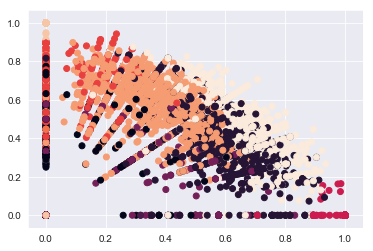

Comparing the assigned categories to the ones in the data:
col_0        0    1   2   3   4   5    6   7    8   9    10
text                                                       
Alice        30  112   0  25   0  10   49   4  174  12   49
Anne         81  134  35  56  46  66  129  19  240  24  195
Christmas    18  112   0  22   0   3   37   2  109  16   98
Gulliver      2   98   4   2   1   4   10   0  107   0   23
Huckleberry  69  180   7  56  31  41  154  15  256  40  156
Moby         22  160  25  36  19  30   20   6  126  33   97
Oz           18  150   0  19   0   0   49   1  213  11   28
Peter        60  134  41  38  50  99  108   8  227  26  218
Prince        0   37   0   7   0   8    3   1   90   1   25
Robinson     20   98   6   7  10   7   23   0  230   8   32
Adjusted Rand Index: -0.00
Silhouette Score: 0.18


In [57]:
n_clusters = 11

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train_pos)

#Predicted clusters.
predict=sc.fit_predict(X_train_pos)

#Graph results.
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train_pos, predict))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train_pos, 
                                                                       predict)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_pos, 
                                                                predict, 
                                                                metric='euclidean')))

### Using tf_idf with POS

In [58]:
df_tfidf_pos = sentences_df.join(df_tfidf, lsuffix='df', rsuffix='tfidf')
df_tfidf_pos.head()

,text_sentences,textdf,adj,adp,adv,aux,cconj,det,intj,noun,...,year,yellow,yes,yesterday,yield,yo,yonder,young,yous,youth
0,"(the, wonderful, wizard, of, oz, by, l, frank,...",Oz,11,16,4,0,0,34,0,44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(the, good, witch, grants, dorothys, wish, home)",Oz,2,0,0,0,0,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"(again, introduction, folklore, legends, myths...",Oz,25,27,9,0,11,32,0,65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"(wife, their, house, was, small, for, the, lum...",Oz,1,2,0,0,0,2,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"(many, miles, there, were, four, walls, a, flo...",Oz,2,1,1,0,5,9,0,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
print(df_tfidf_pos.shape)

(7798, 1937)


In [60]:
df_tfidf_pos_train = df_tfidf_pos.drop(['all_count', 'text_sentences', 'textdf', 
                         'questiondf', 'all_caps', 'sym', 'intj'], axis=1)

In [61]:
#Normalize POS data along feature axis to make up for shorter and longer passages
norm = Normalizer(norm='l2')
Xpos_norm = norm.fit_transform(df_pos[df_pos_cols])

X_train_tf_pos, X_test_tf_pos, y_train_tf_pos, y_test_tf_pos = train_test_split(df_tfidf_pos_train, 
                                                                                sentences_df['text'], 
                                                                                test_size=0.25, 
                                                                                random_state=0)

### LSA with POS

In [62]:
#Have features reduced to 100
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa_tf_pos = lsa.fit_transform(X_train_tf_pos)
X_test_lsa_tf_pos = lsa.transform(X_test_tf_pos)



### K means for POS with LSA

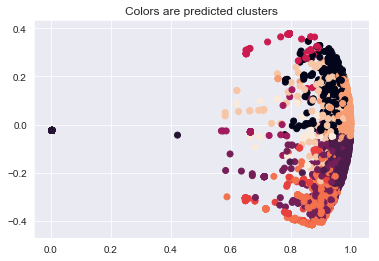

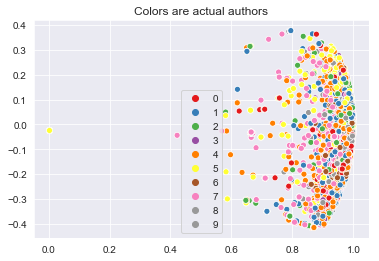

Comparing k-means clusters against the data:
col_0         0   1    2    3   4   5   6    7    8   9   10
text                                                        
Alice         21   0  163   46   0  10  10   37  153  20   5
Anne          77  46  289  107  35  65  18  110  216  47  15
Christmas     30   0  102   23   0   2   7   30  200  13  10
Gulliver      14   1   33    3   4   2   0    8  184   2   0
Huckleberry  104  30  315   91   8  33  18  128  218  35  25
Moby          88  19   76   27  27  18  18   25  230  29  17
Oz            19   0  192   31   0   0  10   29  193  12   3
Peter         65  47  291   93  41  93  20   86  225  27  21
Prince        15   0   48    3   0   3   0    2   97   3   1
Robinson      14  10  132   28   6   5   7   17  216   5   1

Crosstab with label encoded values.  Columns are clusters

col_0   0   1    2    3   4   5   6    7    8   9   10
row_0                                                 
0       21   0  163   46   0  10  10   37  153  20   

In [63]:
y_pred2 = KMeans(n_clusters=11).fit_predict(X_train_lsa_tf_pos)

# Plot the solution.
plt.scatter(X_train_lsa_tf_pos[:, 0], X_train_lsa_tf_pos[:, 1], c=y_pred2)
plt.title('Colors are predicted clusters')
plt.show()

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_tf_pos)
y_test_enc = le.fit_transform(y_test_tf_pos)

sns.scatterplot(X_train_lsa_tf_pos[:, 0], X_train_lsa_tf_pos[:, 1], hue=y_train_enc, legend='full', palette='Set1')
plt.title('Colors are actual authors')
plt.show()
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train_tf_pos, y_pred2))
print('\nCrosstab with label encoded values.  Columns are clusters\n')
print(pd.crosstab(y_train_enc, y_pred2))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train_tf_pos, 
                                                                       y_pred2)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_lsa_tf_pos, 
                                                                y_pred2, 
                                                                metric='euclidean')))

### Mean Shift for POS with LSA

Number of estimated clusters: 6


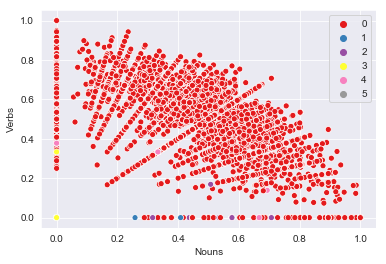

Comparing the assigned categories to the ones in the data:
col_0          0   1   2   3   4  5
text                               
Alice        453   0   0  10   1  1
Anne         877  58  45  41   3  1
Christmas    401   0   0  15   1  0
Gulliver     243   2   5   0   0  1
Huckleberry  893  43   9  46  12  2
Moby         475  31  37  24   7  0
Oz           484   0   0   4   1  0
Peter        848  83  48  26   2  2
Prince       170   0   0   2   0  0
Robinson     414  14   7   5   1  0

Adjusted Rand Index: -0.01
Silhouette Score: 0.30


In [64]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_pos, quantile=0.2)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa_tf_pos)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

sns.scatterplot(X_train_lsa_tf_pos[:, 0], X_train_lsa_tf_pos[:,1], hue=labels, legend='full', palette='Set1')
plt.xlabel('Nouns')
plt.ylabel('Verbs')
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train_pos,labels))
print('\nAdjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train_pos, 
                                                                         labels)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_lsa_tf_pos, 
                                                                 labels, 
                                                                 metric='euclidean')))

### Spectral Clustering POS

### Parts of Speech Spectral Clustering with tfidf

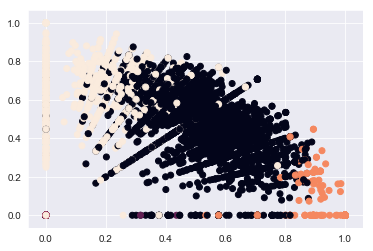

Comparing the assigned categories to the ones in the data:
col_0          0   1   2    3    4
text                              
Alice        288   0   0   16  161
Anne         475  35  46   77  392
Christmas    301   0   0   11  105
Gulliver     220   4   1    4   22
Huckleberry  485   7  32   68  413
Moby         368  25  20   51  110
Oz           347   0   0    0  142
Peter        474  41  51  117  326
Prince       149   0   0   10   13
Robinson     327   6  10    9   89
Adjusted Rand Index: -0.01
Silhouette Score: 0.28


In [65]:

n_clusters = 5

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train_pos)

#Predicted clusters.
predict=sc.fit_predict(X_train_lsa_tf_pos)

#Graph results.
plt.scatter(X_train_lsa_tf_pos[:, 0], X_train_lsa_tf_pos[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train_pos, predict))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train_pos, 
                                                                       predict)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_lsa_tf_pos, 
                                                                predict, 
                                                                metric='euclidean')))

### Conclusion

Overall, our scores are not great. There is certainly room for improvement. One solution might be to manually create a function for getting common words and extracting features from the common words. I have tried going this route but it was too time consuming. Another option that I haven't explored is to use Word2Vec which has a continuous bag of words. 

The children's books I've chosen are from different eras ranging from the 16th century to the 1900's. I was thinking it would be easier to classify to the right book since words from different times may vary but this was not the case. An interesting problem to solve may be comparing classical Children's books to modern day children's books such as Pete the Cat or even Dr. Seuss.

 
I've experimented with cleaning the text multiple times. Cleaning the text could also lead to loss of data so I had to be cautious on how it's done. Overall, the cleaning function I've created is just simple so as not to lose important data. 


Publishing dates for the books: 

The Prince 1513
Crusoe 1719
Gulliver's Travels 1726
A Christmas Carol 1843
Moby Dick 1851
Alice in Wonderland 1865
Huckleberry Finn 1884
Wizard of Oz 1900
Peter Pan 1906
Anne of Green Gables 1908